In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue May  6 10:10:51 2025

@author: nlwagner25
"""

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from TidalPy.structures import build_world, build_from_world
from TidalPy.structures import Orbit

from TidalPy import version
print('TidalPy: ', version)
from TidalPy.RadialSolver import radial_solver
from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays
from TidalPy.rheology import Elastic, Maxwell, Andrade
from TidalPy.RadialSolver import build_rs_input_homogeneous_layers
from TidalPy.structures import build_world
from TidalPy.utilities.conversions import orbital_motion2semi_a
from TidalPy.utilities.numpy_helper import find_nearest
from TidalPy.rheology import Maxwell, SundbergCooper
from TidalPy.tides.potential import tidal_potential_simple, tidal_potential_nsr

TidalPy:  0.6.4rc0


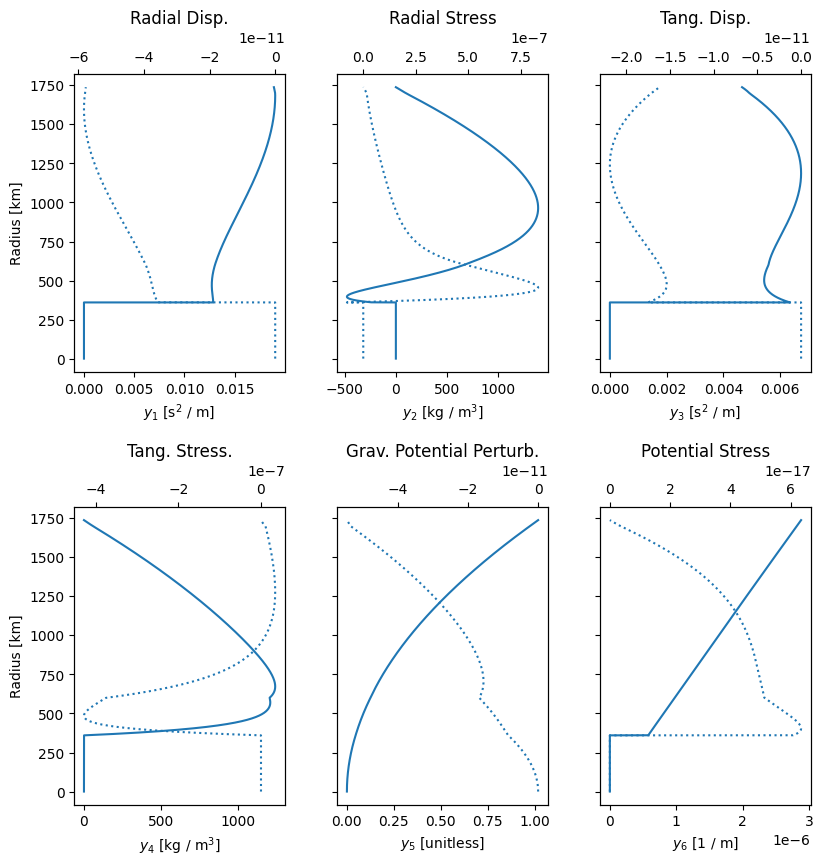

Surface Love & Shida Numbers
k_2 = 1.71e-02-5.46e-11j
h_2 = 3.07e-02-9.37e-11j
l_2 = 7.56e-03-2.63e-11j
[[           nan           +nanj            nan           +nanj
             nan           +nanj ... 1.88966657e-02-5.77277257e-11j
  1.88966502e-02-5.77276972e-11j 1.88966346e-02-5.77276687e-11j]
 [           nan           +nanj            nan           +nanj
             nan           +nanj ... 2.13084912e-02+3.91845437e-12j
  1.06542856e-02+1.95925540e-12j 2.27373675e-13+0.00000000e+00j]
 [           nan           +nanj            nan           +nanj
             nan           +nanj ... 4.65385814e-03-1.62270972e-11j
  4.65382536e-03-1.62270017e-11j 4.65379258e-03-1.62269061e-11j]
 [           nan           +nanj            nan           +nanj
             nan           +nanj ... 1.18311920e-02+1.62738968e-12j
  5.91558080e-03+8.13667289e-13j 1.45519152e-11+2.03287907e-20j]
 [           nan           +nanj            nan           +nanj
             nan           +nanj ... 1.01704

In [16]:
luna = build_world('luna')




radii = luna.radii


param_config = {
    "core_radius":          360E3,
    "core_density":         6000,
    "core_bulk_modulus":    50E9,
    "mantle_density":       3300,
    "mantle_viscosity":     1E25,
    "mantle_bulk_modulus":  90E9,
    "mantle_shear_modulus": 90E9,
    "LVZ_radius":           600E3,
    "LVZ_density":          5400,
    "LVZ_viscosity":        1E25,
    "LVZ_bulk_modulus":     60E9,
    "LVZ_shear_modulus":    80E9,
    
    "LVZ_zeta":             -5,
    "LVZ_alpha":            0.11,
    "mantle_zeta":          -5,
    "mantle_alpha":         0.07
}


cmb = param_config['core_radius']
rho_core = param_config['core_density']
core_K = param_config['core_bulk_modulus']

LVZ_radius = param_config['LVZ_radius']
rho_LVZ = param_config['LVZ_density']
visc_LVZ = param_config['LVZ_viscosity']
LVZ_K = param_config['LVZ_bulk_modulus']
LVZ_mu = param_config['LVZ_shear_modulus']

rho_mantle = param_config['mantle_density']
visc_m = param_config['mantle_viscosity']
mantle_K = param_config['mantle_bulk_modulus']
mantle_mu = param_config['mantle_shear_modulus']

LVZ_zeta = param_config['LVZ_zeta']
mantle_zeta = param_config['mantle_zeta']

LVZ_alpha = param_config['LVZ_alpha']
mantle_alpha = param_config['mantle_alpha']

N = 10000

# Layer properties
layer_types = ("liquid", "solid", "solid", "solid")
is_static_by_layer = (True, False, False, False)
comp = (False, False, False, False)
incomp = (True, True, True, True)
upper_radius_by_layer = (cmb, LVZ_radius, 1738E3 - 40E3, 1738E3)

# Planetary parameters
planet_mass = 7.3463E22
planet_radius = 1738E3
planet_volume = (4 / 3) * np.pi * planet_radius**3
planet_bulk_density = planet_mass / planet_volume

# Interior structure
# print(cmb,LVZ_radius)
r = (cmb/planet_radius, LVZ_radius/planet_radius, (1738E3 - 40E3)/planet_radius, 1.)
rho = (rho_core, rho_LVZ, rho_mantle, 2550.)
mu = (0.0, LVZ_mu, mantle_mu, 20E9)
K = (core_K, LVZ_K, mantle_K, 100E9)
eta = (1E30, visc_LVZ, visc_m, 1E30)



rtol = 1e-8
atol = 1e-8
intmethod = 'RK45'

# Precompute orbital frequency constants
seconds_in_month = 27 * 24 * 60 * 60.
seconds_in_year = 365 * 24 * 60 * 60.
pi_2 = 2 * np.pi

# Precompute forcing frequencies
forcing_frequency_month = pi_2 / seconds_in_month
forcing_frequency_year = pi_2 / seconds_in_year


orbital_freq = 2. * np.pi / seconds_in_month
orbital_period = 2. * np.pi / orbital_freq


shear_rheology_model_tuple = (Maxwell(),Maxwell(),Maxwell(),Maxwell())
# shear_rheology_model_tuple = (Elastic(),Andrade((LVZ_alpha, 10**LVZ_zeta)),Andrade((mantle_alpha, 10**mantle_zeta)),Elastic())
# bulk_rheology_model_tuple = (Elastic(),Andrade((LVZ_alpha, 10**LVZ_zeta)),Andrade((mantle_alpha, 10**mantle_zeta)),Elastic())

# bulk_rheology_model_tuple = (Elastic(),Maxwell(),Maxwell(),Elastic())
bulk_rheology_model_tuple = (Elastic(),Elastic(),Elastic(),Elastic())

rs_inputs_month = build_rs_input_homogeneous_layers(
planet_radius,                    # Radius of planet (float64) [m]
forcing_frequency_month,                # Forcing frequency, used to solve for the complex shear / bulk modulus (float64) [rad s-1]
rho,                    # Tuple of floats for each layer's constant density. (Tuple[float64]; len = num_layers)
K,        # Tuple of floats for each layer's constant static bulk modulus. (Tuple[float64]; len = num_layers)
mu,       # Tuple of floats for each layer's constant static shear modulus. (Tuple[float64]; len = num_layers)             # Tuple of floats for each layer's constant bulk viscosity. (Tuple[float64]; len = num_layers)
(1E30, 1E30, 1E30, 1E30),
eta, # Tuple of floats for each layer's constant shear viscosity. (Tuple[float64]; len = num_layers)
layer_types,                 # Tuple of strings for each layer type. (Tuple[str]; len = num_layers)
is_static_by_layer,            # Tuple of booleans for if each layer should use the static assumption. (Tuple[bool]; len = num_layers)
comp,    # Tuple of booleans for if each layer should use the incompressible assumption. (Tuple[bool]; len = num_layers)
shear_rheology_model_tuple,       # Tuple of rheology instances for each layer's complex shear calculation. (Tuple[RheologyModelBase]; len = num_layers)
bulk_rheology_model_tuple,        # Tuple of rheology instances for each layer's complex bulk calculation. (Tuple[RheologyModelBase]; len = num_layers)
# One of the following tuples must be provided. They define the layer geometry
r,            # (optional, default=None) Tuple of floats for each layer's radius fraction (R_layer / R_Planet).  (Tuple[float64]; len = num_layers)
# thickness_fraction_tuple,         # (optional, default=None) Tuple of floats for each layer's thickness fraction ((R_layer - R_layer_below) / R_Planet).  (Tuple[float64]; len = num_layers)
# volume_fraction_tuple,            # (optional, default=None) Tuple of floats for each layer's volume fraction (V_layer / V_Planet).  (Tuple[float64]; len = num_layers)
# # Each layer is further sub-divided into slices. At least 5 slices per layer is required. 
# slices_tuple,                     # (optional, default=None) Tuple of ints for the number of subslices each layer should be built with. (Tuple[int]; len = num_layers)
slice_per_layer=N,                  # (optional, default=10) Number of slices to build all layers with. Used for each layer if `slices_tuple` is not provided (int)
perform_checks = True             # (optional, default=True) Flag to tell function to perform additional checks on inputs. There is a small performance hit, but recommended unless you are sure your input is valid. (boolean)
)


radial_solution_month = radial_solver(
    *rs_inputs_month,
    degree_l=2,
    solve_for=('tidal',),
    starting_radius = 100.0,
    start_radius_tolerance = 1.0e-5,
    use_kamata=True,
    integration_method=intmethod,
    integration_rtol = rtol,
    integration_atol = atol,
    max_num_steps = 100_000_000,
    expected_size = 500,
    max_ram_MB = 1000,
    max_step = 500,
    nondimensionalize = False,
    verbose = False,
    raise_on_fail = True
    )

k2 = radial_solution_month.k
h2 = radial_solution_month.h
l2 = radial_solution_month.l
tidal_y = radial_solution_month.result


# Plot results and print Love numbers
from TidalPy.utilities.graphics.multilayer import yplot
_ = yplot(tidal_y, radial_solution_month.radius_array)

print('Surface Love & Shida Numbers')
print(f'k_2 = {k2:.2e}\nh_2 = {h2:.2e}\nl_2 = {l2:.2e}')




print(tidal_y)

In [17]:
print(tidal_y[:, 1])

[nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj]


In [18]:
print(radial_solution_month.radius_array[:10])
print(tidal_y[4, :10])

[  0.          36.00360036  72.00720072 108.01080108 144.01440144
 180.0180018  216.02160216 252.02520252 288.02880288 324.03240324]
[           nan           +nanj            nan           +nanj
            nan           +nanj 4.16132717e-09-7.69421508e-19j
 7.39791498e-09-1.36786046e-18j 1.15592422e-08-2.13728197e-18j
 1.66453087e-08-3.07768603e-18j 2.26561146e-08-4.18907267e-18j
 2.95916599e-08-5.47144184e-18j 3.74519446e-08-6.92479359e-18j]


In [19]:
print(np.argwhere(np.isnan(tidal_y)))

[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [1 0]
 [1 1]
 [1 2]
 [1 3]
 [1 4]
 [1 5]
 [2 0]
 [2 1]
 [2 2]
 [2 3]
 [2 4]
 [2 5]
 [3 0]
 [3 1]
 [3 2]
 [3 3]
 [3 4]
 [3 5]
 [4 0]
 [4 1]
 [4 2]
 [5 0]
 [5 1]
 [5 2]
 [5 3]
 [5 4]
 [5 5]]


In [20]:
for i in range(10):
    print(radial_solution_month.radius_array[i])
    for y_i in range(6):
        print("\t", tidal_y[y_i,i].real, tidal_y[y_i,i].imag)

0.0
	 nan nan
	 nan nan
	 nan nan
	 nan nan
	 nan nan
	 nan nan
36.003600360036
	 nan nan
	 nan nan
	 nan nan
	 nan nan
	 nan nan
	 nan nan
72.007200720072
	 nan nan
	 nan nan
	 nan nan
	 nan nan
	 nan nan
	 nan nan
108.01080108010801
	 nan nan
	 nan nan
	 nan nan
	 nan nan
	 4.161327170940609e-09 -7.694215083056074e-19
	 nan nan
144.014401440144
	 nan nan
	 nan nan
	 nan nan
	 nan nan
	 7.397914978867307e-09 -1.3678604607457738e-18
	 nan nan
180.01800180018
	 nan nan
	 nan nan
	 nan nan
	 nan nan
	 1.1559242151041864e-08 -2.137281969279536e-18
	 nan nan
216.02160216021602
	 0.0 0.0
	 0.0 0.0
	 0.0 0.0
	 0.0 0.0
	 1.664530868705618e-08 -3.0776860338314367e-18
	 0.0 0.0
252.02520252025204
	 0.0 0.0
	 0.0 0.0
	 0.0 0.0
	 0.0 0.0
	 2.2656114644534396e-08 -4.18907266505607e-18
	 0.0 0.0
288.028802880288
	 0.0 0.0
	 0.0 0.0
	 0.0 0.0
	 0.0 0.0
	 2.9591659912216303e-08 -5.4714418423816356e-18
	 0.0 0.0
324.032403240324
	 0.0 0.0
	 0.0 0.0
	 0.0 0.0
	 0.0 0.0
	 3.745194463964793e-08 -6.924793